## Keras Binary Classifier for Anomaly Detection with dataset upsampling and category embeddings via Multi-Input

### Loading Necessary Files and Libraries

In [15]:
import keras
from keras.models import Model, Sequential
from keras.layers import Embedding, Input, Dense, LSTM
from keras.preprocessing.text import Tokenizer
from keras import layers
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras import optimizers
import pickle
import os
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
from keras.layers import LeakyReLU
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate
from keras.layers import MaxPooling2D, Flatten, Conv2D
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import shap
from pandas.plotting import scatter_matrix
from plot_utility import plot_confusion_matrix, plot_roc_curve

%matplotlib inline

## Load Data

From: https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

In [2]:
data = pd.read_csv("creditcard.csv")

print(data.shape)

(284807, 31)


In [3]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

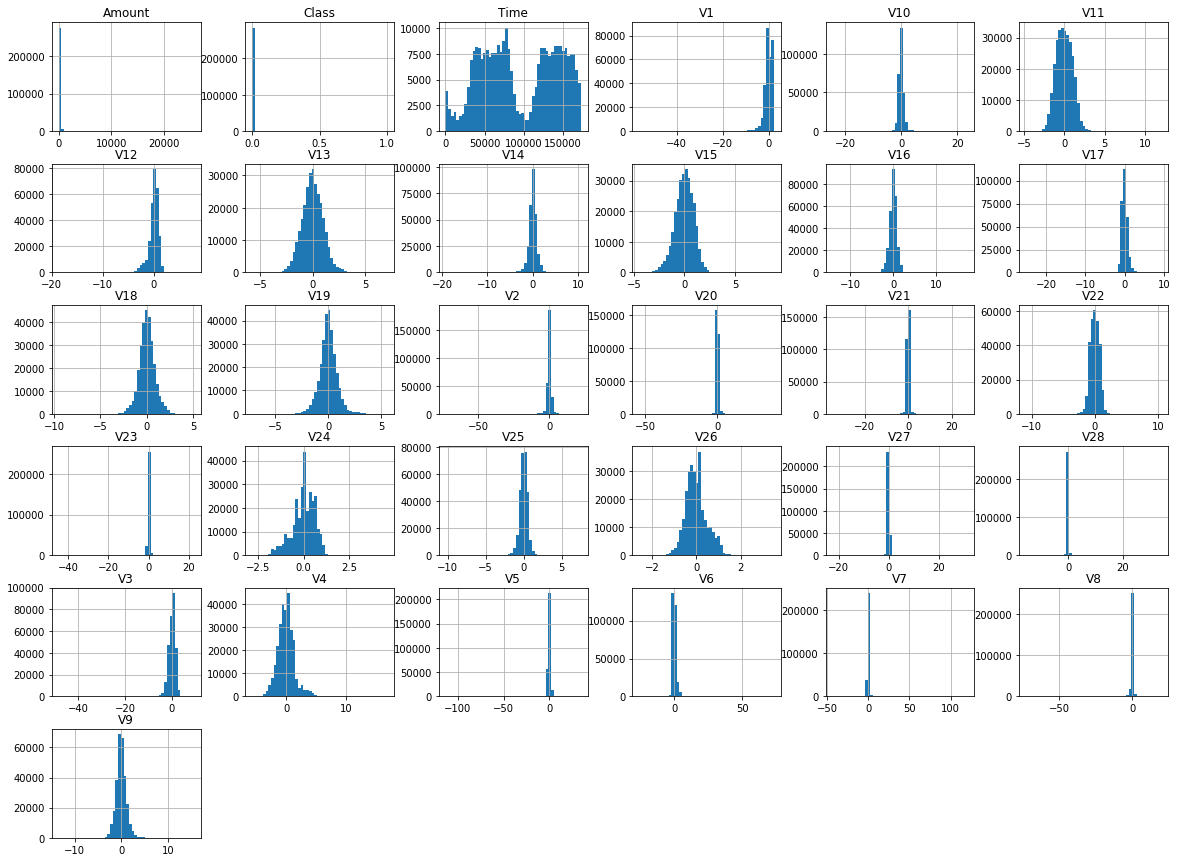

In [5]:
%matplotlib inline
data.hist(bins=50, figsize=(20,15))
plt.show()

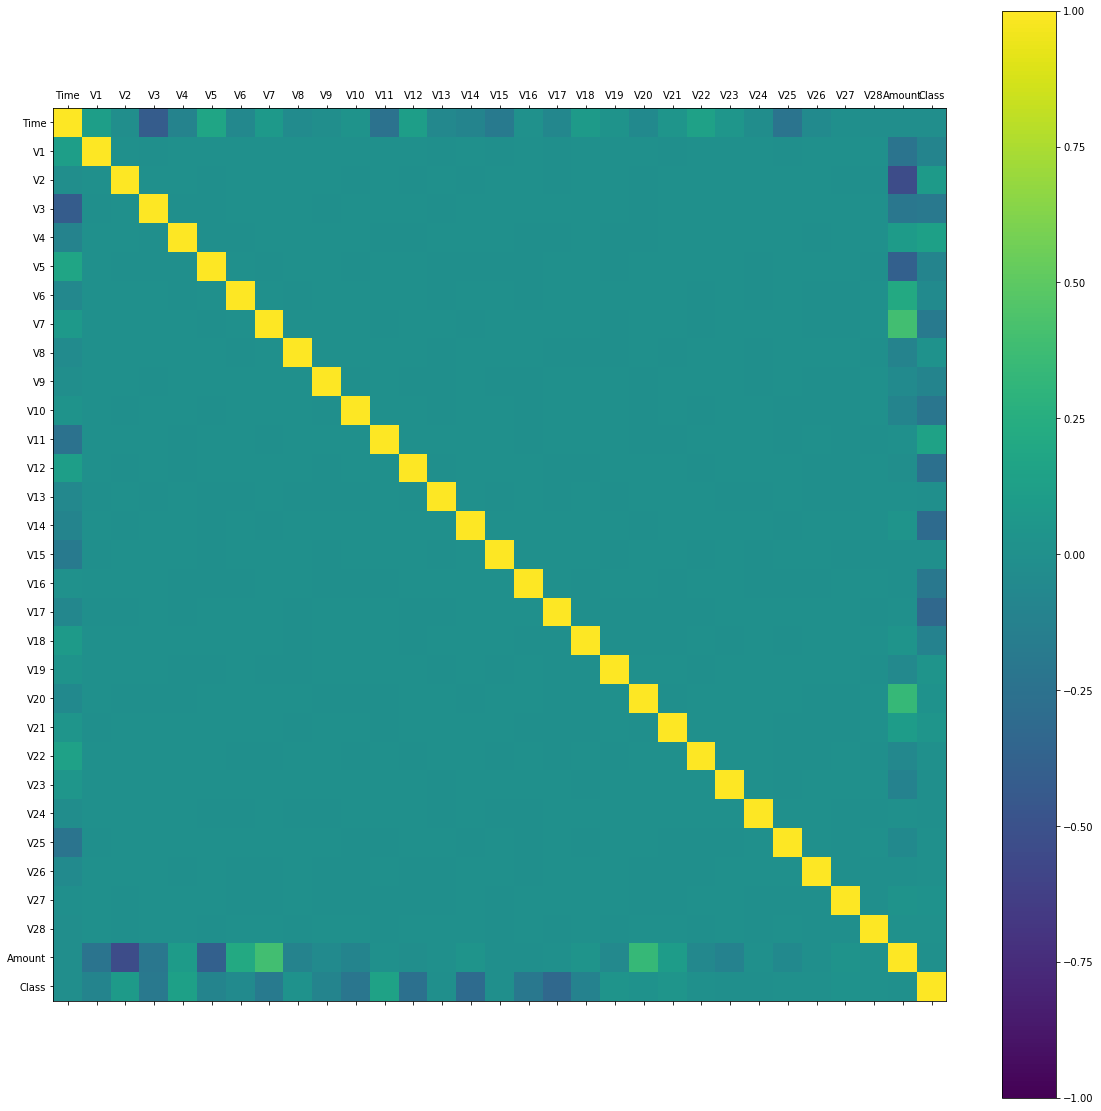

In [25]:
correlations = data.corr()
# plot correlation matrix
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,31,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

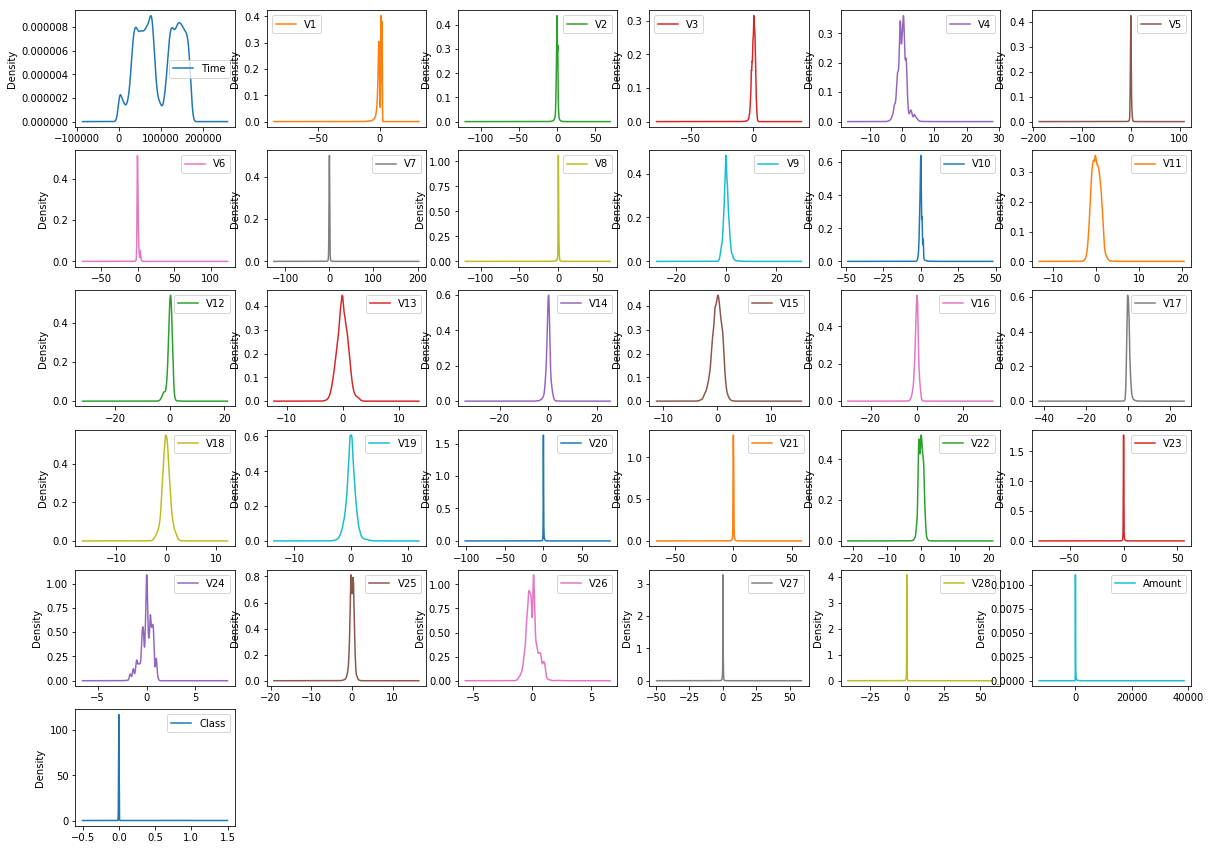

In [13]:
data.plot(kind='density', subplots=True, layout=(6,6), sharex=False, figsize=(20,15))
plt.show()

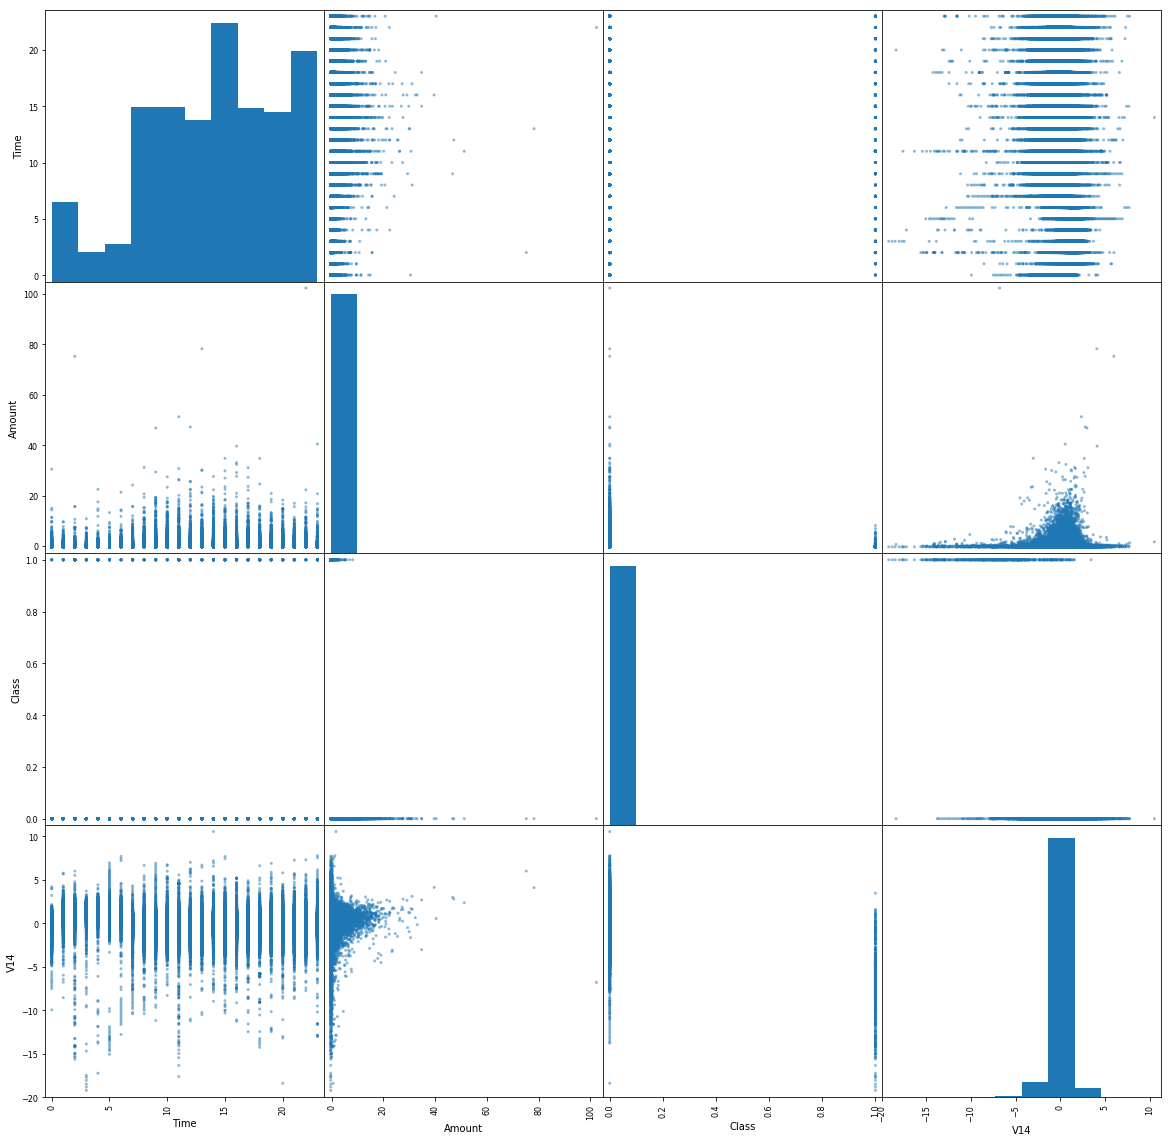

In [72]:
attributes =["Time", "Amount", "Class", "V14"]
scatter_matrix(data[attributes], figsize=(20,20))
plt.show()

## Check Balance Level

In [29]:
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [30]:
print("Balance level: {} %".format(data["Class"].value_counts()[1]*100/data["Class"].value_counts()[0]))

Balance level: 0.17304750013189596 %


# Data Prep

## Normalize Amount using Scaler

In [31]:
data["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

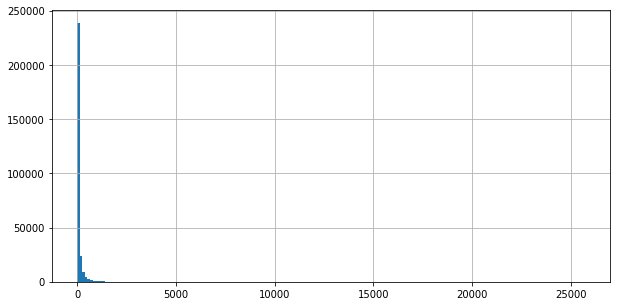

In [32]:
%matplotlib inline
data["Amount"].hist(bins=200, figsize=(10,5))
plt.show()

In [33]:
scaler = preprocessing.StandardScaler()
data["Amount"] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(data["Amount"])),columns=["Amount"])
data["Amount"].describe()

count    2.848070e+05
mean     3.202236e-16
std      1.000002e+00
min     -3.532294e-01
25%     -3.308401e-01
50%     -2.652715e-01
75%     -4.471707e-02
max      1.023622e+02
Name: Amount, dtype: float64

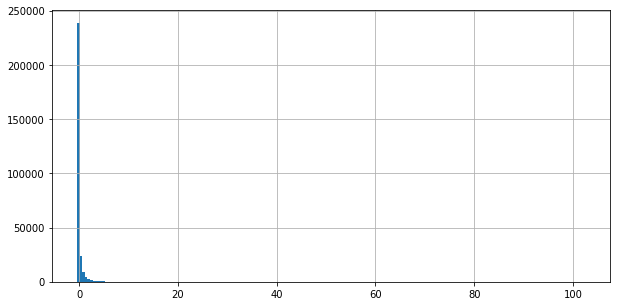

In [34]:
%matplotlib inline
data["Amount"].hist(bins=200, figsize=(10,5))
plt.show()

In [35]:
#data["Amount"].value_counts()
#data.drop("Amount", inplace=True, axis=1)

## Convert Time in Week Day Categories

Number of seconds elapsed between this transaction and the first transaction in the dataset

In [36]:
data["Time"].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

In [37]:
diff_secs = data["Time"].max() - data["Time"].min()
diff_hours = diff_secs/(60*60)
print("Elapsed hours: {}".format(diff_hours))

Elapsed hours: 47.99777777777778


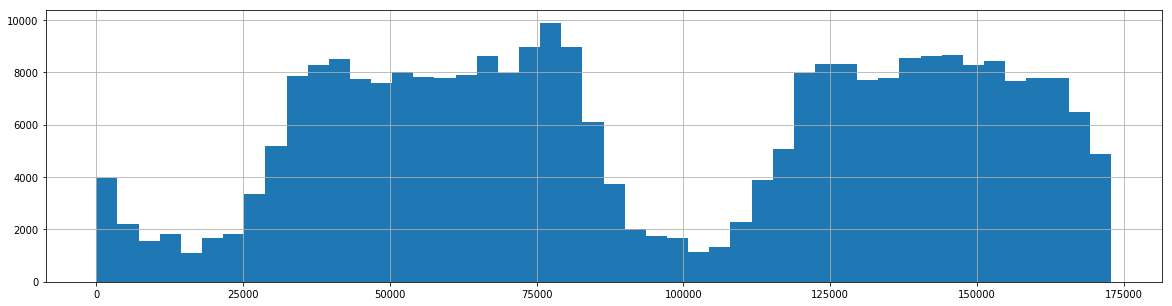

In [38]:
%matplotlib inline
data["Time"].hist(bins=48, figsize=(20,5))
plt.show()

In [39]:
data["Time"] = data["Time"].apply(lambda x: int(x / 3600) % 24)

In [40]:
data["Time"].nunique()

24

In [41]:
data["Time"].describe()

count    284807.000000
mean         14.046470
std           5.835854
min           0.000000
25%          10.000000
50%          15.000000
75%          19.000000
max          23.000000
Name: Time, dtype: float64

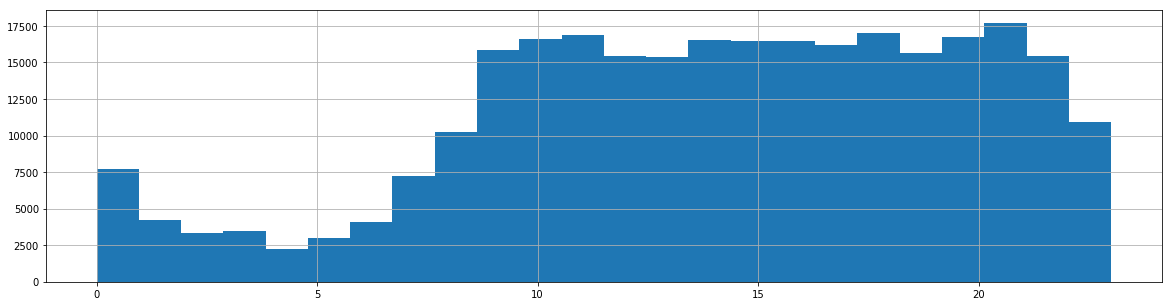

In [42]:
%matplotlib inline
data["Time"].hist(bins=24, figsize=(20,5))
plt.show()

In [43]:
print(data.shape)
data.head(5)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


# Split Train and Test
Train positive data (un-balanced anomalies) is going to be upscaled

#### Check unbalace

In [44]:
print(data["Class"].value_counts())

positive = data[data["Class"] > 0]
negative = data[data["Class"] == 0]

print(positive.shape, negative.shape, positive.shape[0] + negative.shape[0])

0    284315
1       492
Name: Class, dtype: int64
(492, 31) (284315, 31) 284807


#### 80/20 Split Training/Test

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(['Class'], axis=1),
                                                    data['Class'],
                                                    test_size = .2)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(227845, 30) (56962, 30) (227845,) (56962,)


In [46]:
positive = Y_train[Y_train > 0]
negative = Y_train[Y_train == 0]

print(positive.shape, negative.shape, positive.shape[0] + negative.shape[0])

positive = Y_test[Y_test > 0]
negative = Y_test[Y_test == 0]

print(positive.shape, negative.shape, positive.shape[0] + negative.shape[0])

(380,) (227465,) 227845
(112,) (56850,) 56962


#### Oversample via SMOTE

In [47]:
sm = SMOTE()
X_train, Y_train = sm.fit_sample(X_train, Y_train)

positive = Y_train[Y_train > 0]
negative = Y_train[Y_train == 0]

print(positive.shape, negative.shape, positive.shape[0] + negative.shape[0], len(X_train))

(227465,) (227465,) 454930 454930


## Split X_train, X_test in Numerical and Categorical inputs

In [48]:
NUMERICAL_INPUT_SIZE = 29
CATEGORICAL_INPUT_SIZE = 1
NUMBER_OF_CATEGORIES = 1

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

X_train_categorical = X_train[X_train.columns[0:NUMBER_OF_CATEGORIES]]
X_train_numerical = X_train[X_train.columns[NUMBER_OF_CATEGORIES:]] 
print(X_train.shape, X_train_numerical.shape, X_train_categorical.shape)

X_test_categorical = X_test[X_test.columns[0:NUMBER_OF_CATEGORIES]]
X_test_numerical = X_test[X_test.columns[NUMBER_OF_CATEGORIES:]] 
print(X_test.shape, X_test_numerical.shape, X_test_categorical.shape)

(454930, 30) (454930, 29) (454930, 1)
(56962, 30) (56962, 29) (56962, 1)


# Build the Model

## Build the Numerical Model

In [49]:
numerical_input = Input(shape=(NUMERICAL_INPUT_SIZE,))
numerical = Dense(64, activation='relu')(numerical_input)

Instructions for updating:
Colocations handled automatically by placer.


## Build the Embedding Model

In [50]:
categorical_inputs = []
embedding_tensors = []

for category in range(NUMBER_OF_CATEGORIES):
    categorical_input = Input(shape=(CATEGORICAL_INPUT_SIZE,))
    categorical_inputs.append(categorical_input)
    embedding = Embedding(input_dim=24+1, output_dim=12, input_length=CATEGORICAL_INPUT_SIZE)(categorical_input)
    embedding = Flatten()(embedding)
    embedding_tensors.append(embedding)

In [51]:
if len(embedding_tensors) > 1:
    total_concatenated_cat_vars = concatenate(embedding_tensors, axis=1)
else:
    total_concatenated_cat_vars = embedding_tensors[0]

## Merge Numerical and Embedding

In [52]:
input = concatenate([numerical, total_concatenated_cat_vars], axis=1)

## Build the Classifier

In [53]:
hidden = Dense(32, activation='relu')(input)
output = Dense(1, activation='sigmoid')(hidden)

#### Build the Model

In [54]:
inputs = [numerical_input]

for category in range(NUMBER_OF_CATEGORIES):
    inputs.append(categorical_inputs[category])

model = Model(inputs=inputs, outputs=output)

#### Visualize Model Architecture

In [55]:
adam = optimizers.Adam(lr=0.000003, beta_1=0.9, beta_2=0.999, epsilon=1e-4, decay=0.0, amsgrad=True)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


In [56]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 29)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 12)        300         input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           1920        input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 

# Train

In [57]:
X = [X_train_numerical]

for category in range(NUMBER_OF_CATEGORIES):
    X.append(X_train_categorical[X_train_categorical.columns[category]])

In [58]:
# tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', 
#                                          histogram_freq=0, 
#                                          write_graph=True, 
#                                          write_images=True)

# early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=0, verbose=0, mode='auto', baseline=0.003)

model.fit(X, 
          Y_train, 
          epochs=20, 
          batch_size=50, 
          verbose=1,
          shuffle=True,
          #callbacks=[tbCallBack], #, early_stop],
         )  

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
454930/454930 [==============================] - 8s 19us/step - loss: 0.6111 - acc: 0.8035
Epoch 2/20
454930/454930 [==============================] - 8s 18us/step - loss: 0.2711 - acc: 0.9358
Epoch 3/20
454930/454930 [==============================] - 8s 18us/step - loss: 0.1987 - acc: 0.9392
Epoch 4/20
454930/454930 [==============================] - 9s 19us/step - loss: 0.1633 - acc: 0.9426
Epoch 5/20
454930/454930 [==============================] - 8s 18us/step - loss: 0.1430 - acc: 0.9463
Epoch 6/20
454930/454930 [==============================] - 8s 18us/step - loss: 0.1301 - acc: 0.9485
Epoch 7/20
454930/454930 [==============================] - 8s 18us/step - loss: 0.1211 - acc: 0.9510
Epoch 8/20
454930/454930 [==============================] - 8s 18us/step - loss: 0.1140 - acc: 0.9547
Epoch 9/20
454930/454930 [==============================] - 8s 17us/step - loss: 0.1083 - acc: 0.9580
Epoch 10/20
454930/454930 [=======

# Test

In [59]:
X = [X_test_numerical]

for category in range(NUMBER_OF_CATEGORIES):
    X.append(X_test_categorical[X_test_categorical.columns[category]])
    
Y_probas = model.predict(X)

In [60]:
print(len(Y_probas), len(Y_probas[Y_probas >= 0.5]))

56962 1000


In [61]:
Y_pred = [1 if x >= 0.5 else 0 for x in Y_probas]

In [62]:
def print_performance(TP, FP, FN, TN):
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = (TP) / (TP + FP)
    recall = (TP) / (TP + FN)
    fscore = 2 * ((precision * recall) / (precision + recall))

    print('accuracy: {}'.format(accuracy))
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))

In [63]:
cm = confusion_matrix(Y_pred, Y_test["Class"])
cm

array([[55950,    12],
       [  900,   100]])

In [64]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

print(TP, FP, FN, TN)
print_performance(TP, FP, FN, TN)

55950 12 900 100
accuracy: 0.9839893262174784
precision: 0.9997855687788142
recall: 0.9841688654353562
fscore: 0.9919157536432295


In [65]:
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

print(TP, FP, FN, TN)
print_performance(TP, FP, FN, TN)

100 12 900 55950
accuracy: 0.9839893262174784
precision: 0.8928571428571429
recall: 0.1
fscore: 0.1798561151079137


In [66]:

accuracy = accuracy_score(Y_test["Class"], Y_pred)
precision, recall, fscore, support = score(Y_test["Class"], Y_pred)

print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

accuracy: 0.9839893262174784
precision: [0.99978557 0.1       ]
recall: [0.98416887 0.89285714]
fscore: [0.99191575 0.17985612]
support: [56850   112]


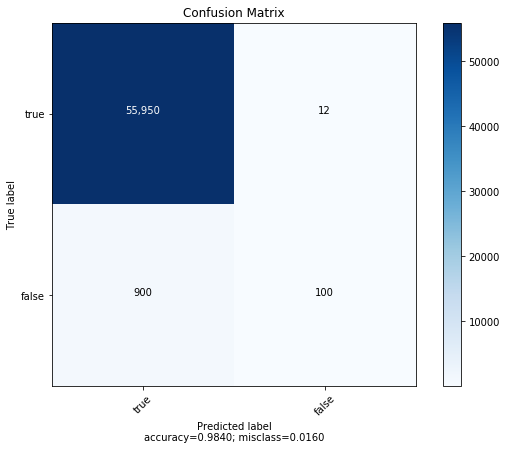

In [67]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['true', 'false'],
                      title        = "Confusion Matrix")

In [68]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(Y_test["Class"], Y_probas)
roc_auc = auc(fpr, tpr)

print(roc_auc)

0.9788128219625581


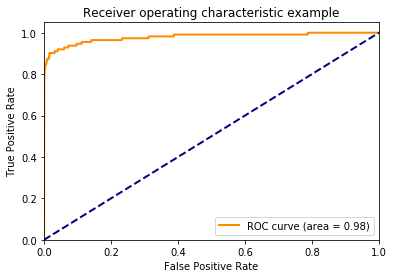

In [69]:
plot_roc_curve(fpr, tpr, roc_auc)

In [70]:
train_sample = np.random.choice(X_train_numerical.shape[0], 1000, replace=False)
test_sample = np.random.choice(X_test_numerical.shape[0], 1000, replace=False)

X_train_numerical_shap = X_train_numerical.iloc[train_sample,:]
X_train_categorical_shap = X_train_categorical.iloc[train_sample,:]
X_test_numerical_shap = X_test_numerical.iloc[test_sample,:]
X_test_categorical_shap = X_test_categorical.iloc[test_sample,:]

X_train_categorical_pd = pd.DataFrame(X_train_categorical_shap[X_train_categorical_shap.columns[0]])
X_test_categorical_pd = pd.DataFrame(X_test_categorical_shap[X_test_categorical_shap.columns[0]])

X1 = [pd.get_dummies(X_train_numerical_shap), pd.get_dummies(X_train_categorical_pd)]
X2 = [pd.get_dummies(X_test_numerical_shap), pd.get_dummies(X_test_categorical_pd)]

X1[1].columns = ['Time']
X1[0].columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

X1[0] = X1[0].values
X1[1] = X1[1].values
X2[0] = X2[0].values
X2[1] = X2[1].values

explainer = shap.DeepExplainer(model, X1)
shap_values = explainer.shap_values(X2)


Instructions for updating:
Use tf.cast instead.


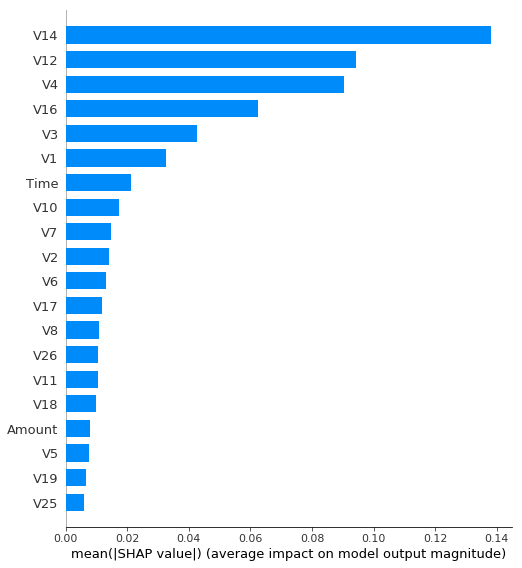

In [71]:
shap.summary_plot(np.hstack(shap_values[0]), np.hstack(X2), plot_type="bar", \
                 feature_names=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', \
                                'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', \
                                'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Time'])